## Henry Crawford 
### EOSC510: Assignment 4
### NN MLP

In [1]:
#import required libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor

In [2]:
#define RMSE as a function, since we'll use this in the NN model 
def rmse(target,prediction):
    return(np.sqrt(((target - prediction)**2).sum()/len(target)))

In [3]:
#load the data, standardize and check it out (here we also normalize g)
data = pd.read_csv('data.csv') 
#data_norm = (data - data.mean())/data.std() # data given is already normalzed

print(data)

          x1        x2         y    x1test    x2test
0   0.750316 -0.895471  0.826006 -0.389106 -0.930149
1  -0.364201 -0.394328 -0.332817 -0.772007 -0.109266
2  -0.453532  0.837857  0.639120  0.699583  0.258593
3   0.353005 -0.237980  0.950115 -0.556922  0.233014
4  -0.857658 -0.500195 -1.903455 -0.196649 -0.914844
..       ...       ...       ...       ...       ...
75  0.734565  0.661976  0.605915       NaN       NaN
76  0.044356 -0.145850  0.981302       NaN       NaN
77 -0.877585  0.803609  0.464791       NaN       NaN
78  0.320672 -0.305835  1.072720       NaN       NaN
79 -0.066723  0.364952  1.408137       NaN       NaN

[80 rows x 5 columns]


In [4]:
#unpack normalized data
x = data.filter(['x1', 'x2'])
x1 = data['x1']
x2 = data['x2']

xtest = data.filter(['x1test', 'x2test'])
x1test = data['x1test']
x2test = data['x2test']

y = data['y']

xy = data.filter(['x1', 'x2','y'])

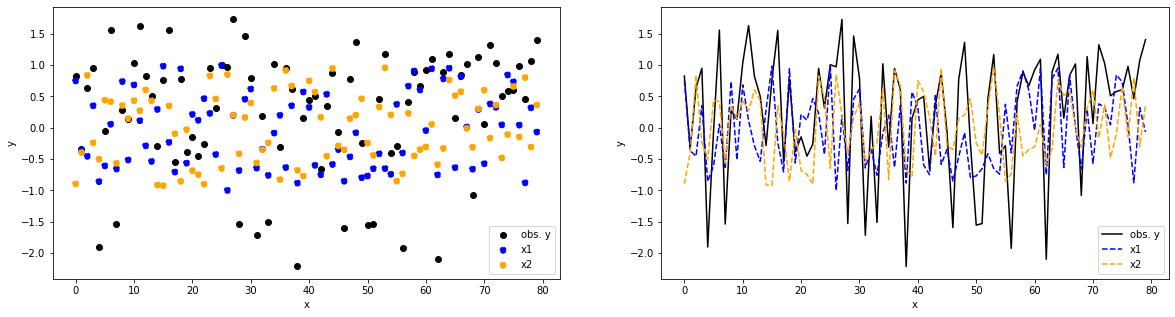

In [5]:
plt.figure(figsize = (20,5))

plt.subplot(1,2,1)
plt.scatter((range(len(y))),y,color='black', label = 'obs. y', ls = '-')
plt.scatter((range(len(x1))),x1,color='blue', label = 'x1', ls = '--')
plt.scatter((range(len(x2))),x2,color='orange', label = 'x2', ls = '--')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.subplot(1,2,2)
plt.plot(y, c='k', label ='obs. y')
plt.plot(x1, color='blue', label = 'x1', ls = '--')
plt.plot(x2, color='orange', label = 'x2', ls = '--')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.show()

In [6]:
# SEQUENTIAL SELECTION OF TRAIN/TEST & STANDARDIZED

fracTrain = 0.8 #fraction of data to use for testing
ntrain = int(len(y)*fracTrain)

x_train = x[:ntrain] #train on n observations
y_train = y[:ntrain]

x_test = x[ntrain:] #test on remaining observations
y_test = y[ntrain:]

print(np.shape(x_train))
print(np.shape(x_test))

(64, 2)
(16, 2)


In [41]:
#This chunk of code is relatively flexible and can be used to loop through a range of parameters
#We'll use this code several different times in the notebook
#Play around and see what kinds of models you can make

#First: MLP using 1 hidden layer with 10 neurons
#Second: MLP using 1 hidden layer with 1-10 neurons
#Third: play around with it!

##### Play around with these parameters
num_models = 11 #number of models to build for the ensemble
min_nhn = 1 #minimum number of hidden neurons to loop through (nhn = 'number hidden neurons')
max_nhn = 15 #maximum number of hidden neurons to loop through
max_hidden_layers = 4 #maximum number of hidden layers to loop through (nhl = 'number hidden layers')
batch_size = 32
solver = 'lbfgs' #use stochastic gradient descent as an optimization method (weight updating algorithm)
activation = 'relu'
learning_rate_init = 0.005
momentum = 0.90
max_iter = 1500 #max number of epochs to run
early_stopping = True #True = stop early if validation error begins to rise
validation_fraction = 0.25 #fraction of training data to use as validation
alpha = 0.01
#####

y_out_all_nhn = []
y_out_ensemble = []
RMSE_ensemble = [] #RMSE for each model in the ensemble
nhn_best = []
nhl_best = []
model_best = []

for model_num in range(num_models): #for each model in the ensemble
    
    print('Model Number: ' + str(model_num))
    
    RMSE = []
    y_out_all_nhn = []
    nhn = []
    nhl = []
    model_store = []
    for num_hidden_layers in range(1,max_hidden_layers+1):
    
        print('\t # Hidden Layers = ' + str(num_hidden_layers))
    
        for num_hidden_neurons in range(min_nhn,max_nhn+1): #for each number of hidden neurons

            print('\t\t # hidden neurons = ' + str(num_hidden_neurons))
            
            hidden_layer_sizes = (num_hidden_neurons,num_hidden_layers)
            model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                                 verbose=False,
                                 max_iter=max_iter, 
                                 early_stopping = early_stopping,
                                 validation_fraction = validation_fraction,
                                 batch_size = batch_size,
                                 solver = solver,
                                 activation = activation,
                                 learning_rate_init = learning_rate_init,
                                 momentum = momentum,
                                alpha = alpha)

            model.fit(x_train,y_train) #train the model

            y_out_this_nhn = model.predict(x_test) #model prediction for this number of hidden neurons (nhn)
            y_out_all_nhn.append(y_out_this_nhn) #store all models -- will select best one best on RMSE

            RMSE.append(rmse(y_test,y_out_this_nhn)) #RMSE between cumulative curves
            
            nhn.append(num_hidden_neurons)
            nhl.append(num_hidden_layers)
            model_store.append(model)
        
    indBest = RMSE.index(np.min(RMSE)) #index of model with lowest RMSE
    RMSE_ensemble.append(np.min(RMSE))
    nhn_best.append(nhn[indBest])
    nhl_best.append(nhl[indBest])
    #nhn_best.append(indBest+1) #the number of hidden neurons that achieved best model performance of this model iteration
    y_out_ensemble.append(y_out_all_nhn[indBest])
    model_best.append(model_store[indBest])
    
    print('\t BEST: ' + str(nhl_best[model_num]) + ' hidden layers, '+ str(nhn_best[model_num]) + ' hidden neurons')
    
y_out_ensemble_mean = np.mean(y_out_ensemble,axis=0)
#RMSE_ensemble_mean = rmse(y_out_ensemble_mean,y_test)
RMSE_ensemble_mean = rmse(y_test, y_out_ensemble_mean)

Model Number: 0
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11
		 # hidden neurons = 12
		 # hidden neurons = 13
		 # hidden neurons = 14
		 # hidden neurons = 15
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11
		 # hidden neurons = 12
		 # hidden neurons = 13
		 # hidden neurons = 14
		 # hidden neurons = 15
	 # Hidden Layers = 3
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neuron

In [42]:
y_pred_best = []
RMSE_best = []

for i in range (len(model_best)):
    y_pred = model_best[i].predict(x_test)
    RMSE_best.append(rmse(y_test,y_pred))
    y_pred_best.append(y_pred)

y_pred_best_ensemble = np.mean(y_pred_best,axis=0)
RMSE_best_ensemble = rmse(y_test, y_pred_best_ensemble)

print(y_pred_best_ensemble)
print(RMSE_best_ensemble)

[ 0.89870618  0.22547573  0.84942959  1.0515246  -1.15019572  1.08457478
  0.41445132  1.06507593  1.02002032  0.29629815  0.94222905  0.83825469
  0.96279488  0.69486439  0.99801946  1.17735962]
0.19707087667813042


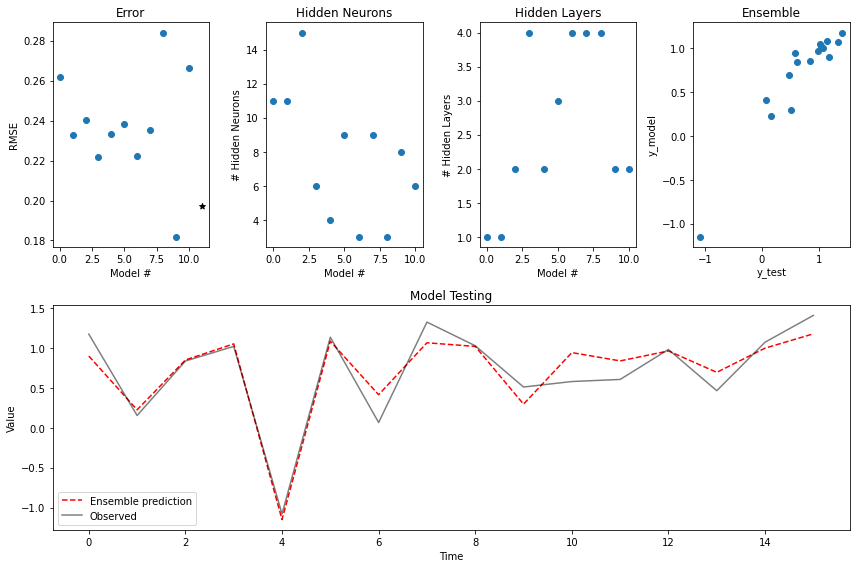

In [43]:
#visualize

plt.figure(figsize=(12,8))

plt.subplot(241)
plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*')
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble)
plt.xlabel('Model #')
plt.ylabel('RMSE')
plt.title('Error')

plt.subplot(242)
plt.scatter(range(len(nhn_best)),nhn_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Neurons')
plt.title('Hidden Neurons')

plt.subplot(243)
plt.scatter(range(len(nhl_best)),nhl_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Layers')
plt.title('Hidden Layers')

plt.subplot(244)
plt.scatter(y_test,y_out_ensemble_mean)
#plt.plot((np.min(y_test),np.max(y_test)),'k--')
plt.xlabel('y_test')
plt.ylabel('y_model')
plt.title('Ensemble')

plt.subplot(212)
plt.plot(y_out_ensemble_mean, color = 'red', label = 'Ensemble prediction', linestyle = '--')
plt.plot(np.array(y_test),alpha = 0.5, color = 'black', label = 'Observed', linestyle = '-')
plt.title('Model Testing')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()

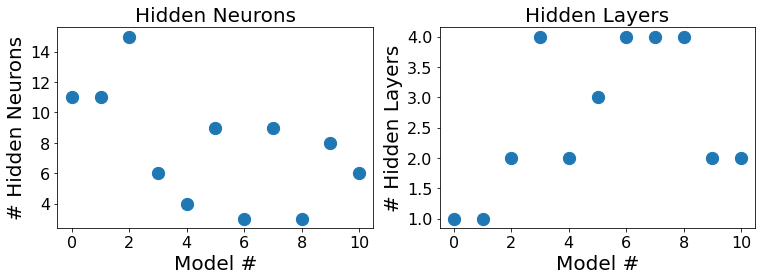

In [44]:
#visualize performance metrics/etc

saveIt = 0

plt.figure(figsize=(16,4))

plt.subplot(131)
plt.scatter(range(len(nhn_best)),nhn_best, s = 150)
plt.xlabel('Model #', fontsize = 20)
plt.ylabel('# Hidden Neurons', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Hidden Neurons', fontsize = 20)

plt.subplot(132)
plt.scatter(range(len(nhl_best)),nhl_best, s = 150)
plt.xlabel('Model #', fontsize = 20)
plt.ylabel('# Hidden Layers', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Hidden Layers', fontsize = 20)

plt.tight_layout()

if saveIt:
    plt.savefig('tutorial10_fig10.png')
    
plt.show()

Text(0.5, 1.0, 'Error')

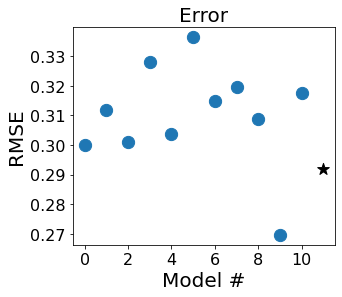

In [11]:
plt.figure(figsize=(16,4))
plt.subplot(131)
plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*', s = 150)
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble, s = 150)
plt.xlabel('Model #', fontsize = 20)
plt.ylabel('RMSE', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
#plt.ylim((np.min(RMSE_ensemble) - 0.005, np.max(RMSE_ensemble)+0.005))
plt.title('Error', fontsize = 20)

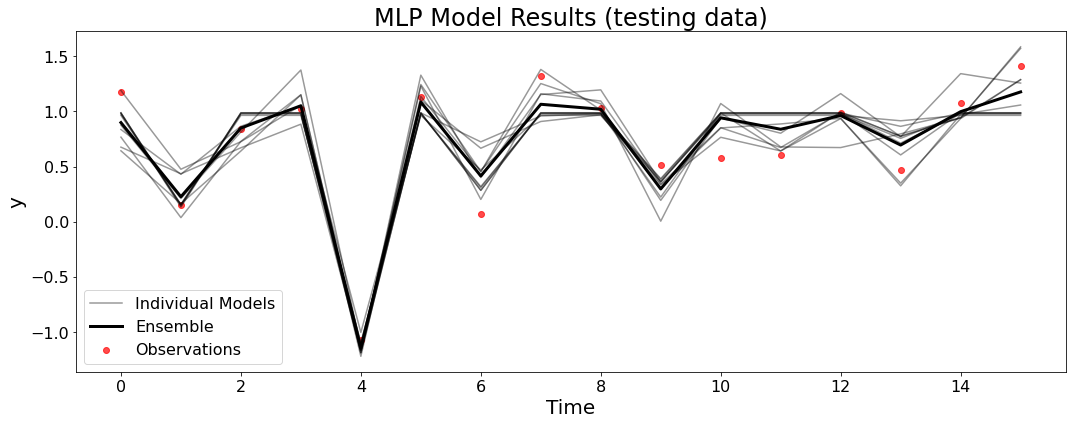

In [46]:
#visualize individual model runs

saveIt = 0

plt.figure(figsize = (15,6))

plt.scatter(range(len(y_test)),y_test,label='Observations',zorder = 0, color = 'red', alpha = 0.7)
plt.plot(range(len(y_test)),np.transpose(y_out_ensemble[0]),color = 'k',alpha = 0.4,label='Individual Models',zorder=1) #plot first ensemble member with a label
plt.plot(range(len(y_test)),np.transpose(y_out_ensemble[1:]),color = 'k',alpha = 0.4, zorder=1) #plot remaining ensemble members without labels for a nicer legend
plt.plot(range(len(y_test)),y_out_ensemble_mean,color = 'k',label = 'Ensemble',zorder=2, linewidth = 3) # plot ensemble

plt.xlabel('Time', fontsize = 20)
plt.ylabel('y', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('MLP Model Results (testing data)', fontsize = 24)
plt.legend(fontsize = 16, loc = 'best')

plt.tight_layout()

if saveIt:
    plt.savefig('tutorial10_fig12.png')

plt.show()

In [47]:
# Extract xtest data 
ntest = 40
xtest_test = xtest[:ntest]
ytest_test = y[:ntest]

# run model ensemble against new x data
y_pred_best = []
RMSE_best = []

for i in range (len(model_best)):
    y_pred = model_best[i].predict(xtest_test)
    RMSE_best.append(rmse(ytest_test,y_pred))
    y_pred_best.append(y_pred)

y_pred_best_ensemble = np.mean(y_pred_best,axis=0)
RMSE_best_ensemble = rmse(ytest_test, y_pred_best_ensemble)

print(y_pred_best_ensemble)
print(RMSE_best_ensemble)

[-2.15089856 -1.15331204  0.88876876  0.2362914  -1.71181654 -1.57231297
  0.93941988  1.00183157  0.86365049  0.83553896  0.83731488  0.99011003
  1.1373058   0.92203468  0.53065403 -0.45848504  0.8652172  -2.2120649
  0.63974029  0.97725225  0.88795929 -2.71978975  0.15454455  0.84918752
 -0.22767516  0.57640171  0.95077484 -2.23041512 -0.90203487  0.53680014
  0.80425992 -1.56558053 -1.48495721 -0.24597751 -0.7882655   0.2097221
  1.09898455  0.53325069  0.82615308  0.52447967]
1.315855863483698


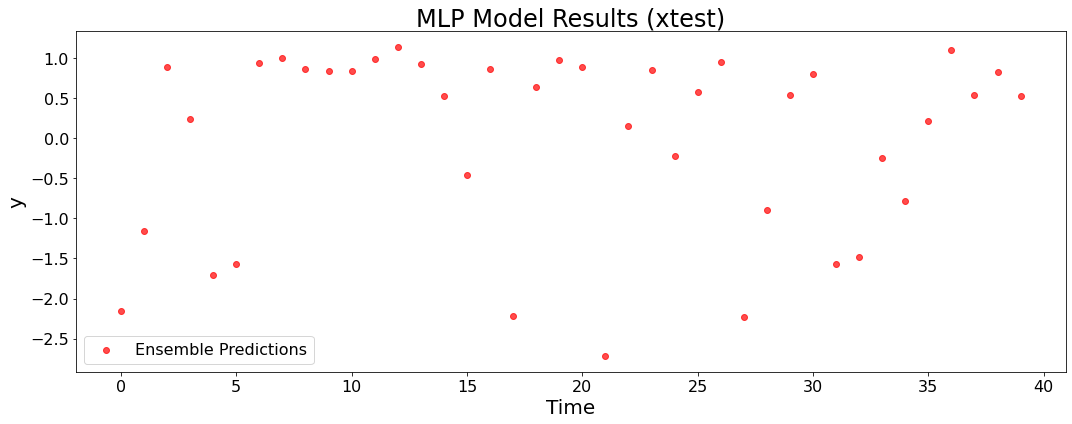

In [59]:
# DONT PLOT AGAINST EXISTING Y DATA
#visualize individual model runs for predicted data

saveIt = 0

plt.figure(figsize = (15,6))

#plt.scatter(range(len(ytest_test)),ytest_test,label='Observations',zorder = 0, color = 'red', alpha = 0.7)
#plt.plot(range(len(ytest_test)),ytest_test,zorder = 0, color = 'red', alpha = 0.3)

#plt.plot(range(len(ytest_test)),np.transpose(y_pred_best[0]),color = 'k',alpha = 0.4,label='Individual Models',zorder=1) #plot first ensemble member with a label
#plt.plot(range(len(ytest_test)),np.transpose(y_pred_best[1:]),color = 'k',alpha = 0.4, zorder=1) #plot remaining ensemble members without labels for a nicer legend
#plt.plot(range(len(ytest_test)), y_pred_best_ensemble, linewidth = 3, color = 'red', linetype = '--') # plot ensemble
plt.scatter(range(len(ytest_test)), y_pred_best_ensemble,label='Ensemble Predictions', color = 'red', alpha = 0.7)

plt.xlabel('Time', fontsize = 20)
plt.ylabel('y', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('MLP Model Results (xtest)', fontsize = 24)
plt.legend(fontsize = 16, loc = 'best')

plt.tight_layout()

if saveIt:
    plt.savefig('tutorial10_fig12.png')

plt.show()

In [57]:
y_pred_best_ensemble_df = pd.DataFrame({'y_pred': y_pred_best_ensemble})
y_pred_best_ensemble_df.to_csv('ytest_Crawford.csv',index=False)